In [7]:
import numpy as np
from SALib.sample import fast_sampler
from SALib.analyze import sobol
from SALib.analyze import fast
import matplotlib.pyplot as plt
from SALib import ProblemSpec
from SALib.sample import saltelli

##########################
#http0.1://salib.readthedocs.io/en/latest/basics_with_interface.html
##########################
import sys
import os
sys.path.insert(0, os.path.abspath('../model'))
import Pacejka52 as pa52
import Pacejka52_Sv_Sh_0 as pa52_0
import Pacejka52_params_comp as pa52pa

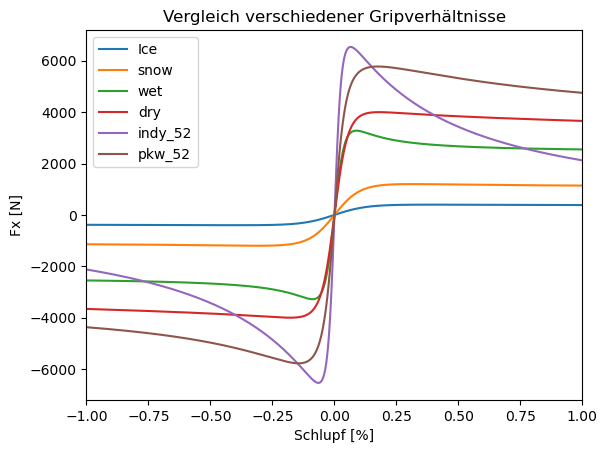

In [11]:
#
#Vergleich verschiedener Reifen, Schne, Eis, Normal pkw, rennreifen
#
# https://de.mathworks.com/help/sdl/ref/tireroadinteractionmagicformula.html
#
# longitutinal

params_ice = [4 ,2 ,0.1 ,1]
params_snow = [5, 2, 0.3, 1]
params_wet = [12, 2.3,0.82, 1]
params_dry = [10,1.9,1,0.97]
params_indy =  [17.04378049 , 1.99996234 , 1.82504605 , 0.62177794]
params_pkw = [4.7,2,2,1]

i = 1000
Sx = np.linspace(-1,1,i)
Sy = np.linspace(-0.3,0.3,i)
Fz = 4000
IA = 0
Fz0 = 3114

Fx_ice = pa52.Pacejka5_long_pa(Sx,Fz,*params_ice)
Fx_snow = pa52.Pacejka5_long_pa(Sx,Fz,*params_snow)
Fx_wet = pa52.Pacejka5_long_pa(Sx,Fz,*params_wet)
Fx_dry = pa52.Pacejka5_long_pa(Sx,Fz,*params_dry)
Fx_indy = pa52.Pacejka5_long_pa(Sx,Fz,*params_indy)
Fx_pkw = pa52.Pacejka5_long_pa(Sx,Fz,*params_pkw)
Fx_indy_52 = pa52pa.Pacejka52_long(Fz,Sx,IA,Fz0,'INDY')[0]
Fx_pkw_52 = pa52pa.Pacejka52_long(Fz,Sx,IA,Fz0,'PKW')[0]

plt.figure(1)
plt.plot(Sx,Fx_ice, label =  'Ice')
plt.plot(Sx,Fx_snow, label =  'snow')
plt.plot(Sx,Fx_wet, label =  'wet')
plt.plot(Sx,Fx_dry, label =  'dry')
#plt.plot(Sx,Fx_indy, label =  'indy')
#plt.plot(Sx,Fx_pkw, label = 'pkw')
plt.plot(Sx,Fx_indy_52, label = 'indy_52')
plt.plot(Sx,Fx_pkw_52, label = 'pkw_52')
plt.xlim(-1,1)
plt.xlabel('Schlupf [%]')
plt.ylabel('Fx [N]')
plt.title('Vergleich verschiedener Gripverhältnisse')
plt.legend()

c:\Users\bener\anaconda3\lib\site-packages\SALib\analyze\sobol.py:129: RuntimeWarning: invalid value encountered in true_divide
  Y = (Y - Y.mean()) / Y.std()


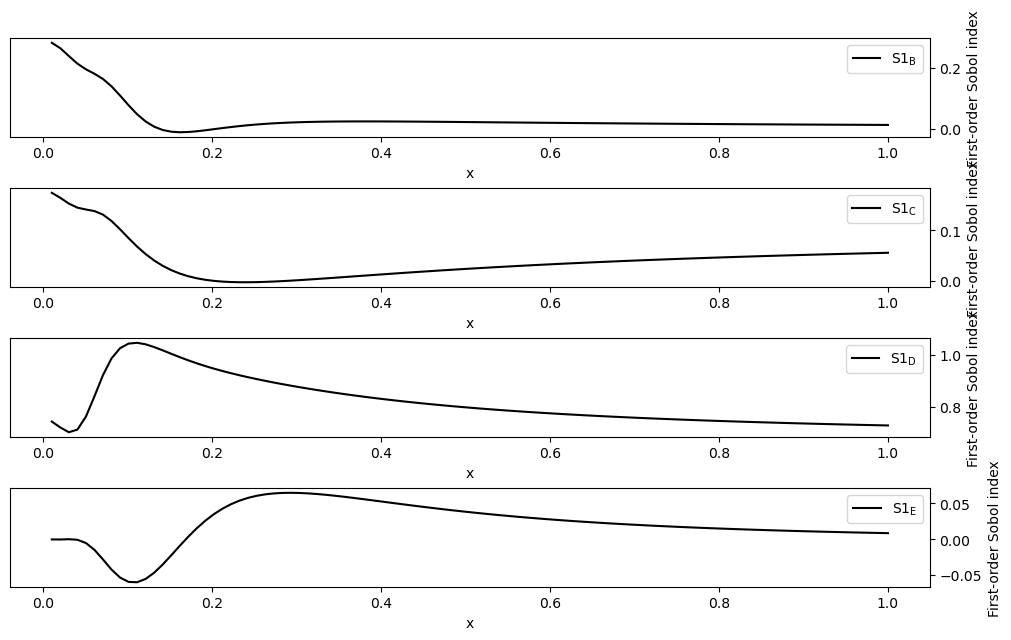

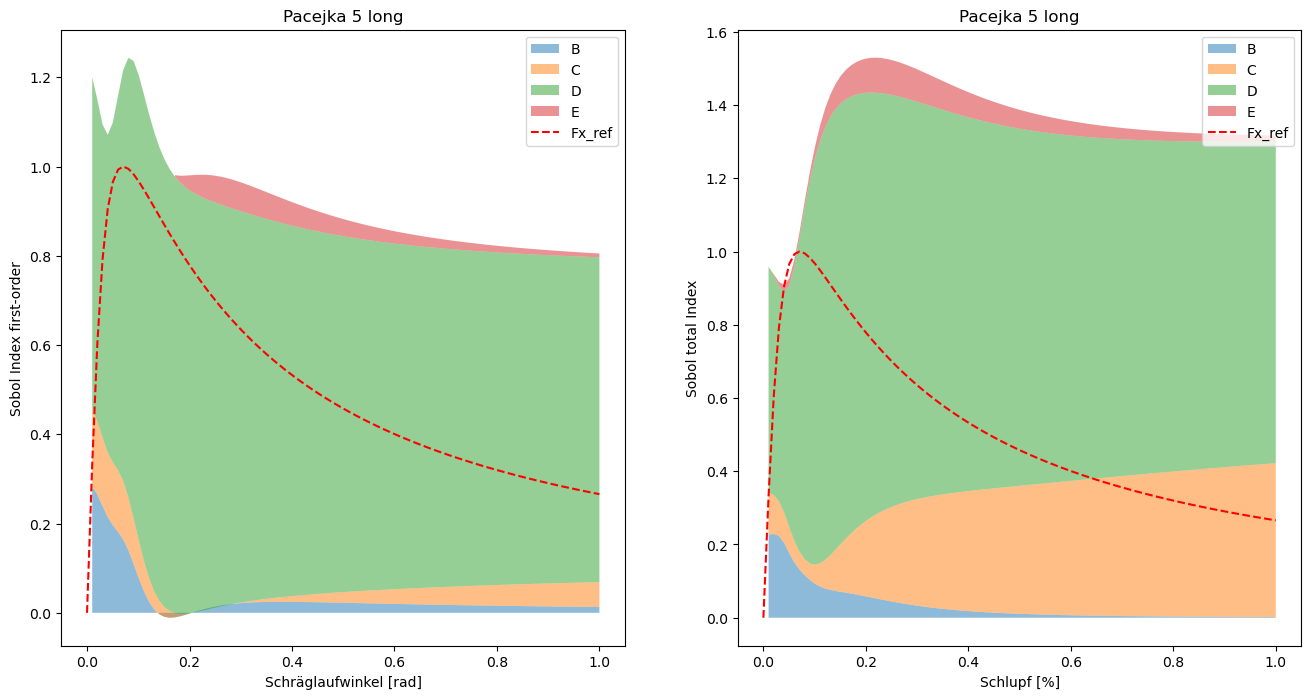

In [13]:
######
# gloabel SA mit Sobol  
######

#same SA for Pacejka5 lateral

import numpy as np
import matplotlib.pyplot as plt
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib import ProblemSpec
SL = np.linspace(0,1,100)

#function
def Pacejka5_long_pa(SL,B,C,D,E):

    Fx= 4000 * D * np.sin(C * np.arctan(B * SL -E * (B*SL - np.arctan(B * SL)))) 
    
    return Fx
params_SA_Fy = [17.04378049 , 1.99996234 , 1.82504605 , 0.62177794]
F_ref = Pacejka5_long_pa(SL,*params_SA_Fy)
F_max = np.max(F_ref)
F_ref_plt = np.zeros(len(F_ref))
for i in range(0, len(F_ref)):
    F_ref_plt[i] = F_ref[i] / F_max
s=0.1
sp = ProblemSpec({
    'num_vars': 4,
    'names': ['B', 'C', 'D', 'E'],
    'bounds': [[4,12], [1, 2], [0.1, 1.9], [-10, 1]],
})


# Create wrapper (runs each a, b combination separately)
def wrapped_function(ab, SL=SL):
    y = np.zeros((ab.shape[0], SL.shape[0]))
    for i, (B,C,D,E) in enumerate(ab):
        y[i,:] = Pacejka5_long_pa(SL,B,C,D,E)

    return y

(
sp.sample_sobol(2**4) #16000 iterationen
.evaluate(wrapped_function)
.analyze_sobol()
)

S1s = np.array([sp.analysis[_y]['S1'] for _y in sp['outputs']])

STs = np.array([sp.analysis[_y]['ST'] for _y in sp['outputs']])
y = sp.results

#Plot: Sensitivity Index für jeden Wert von SL
# Set up figure
fig = plt.figure(figsize=(10, 6), constrained_layout=True)
gs = fig.add_gridspec(4, 1)

ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[2, 0])
ax3 = fig.add_subplot(gs[3, 0])
# Populate figure subplots
for i, ax in enumerate([ax0, ax1, ax2, ax3]):
    ax.plot(SL, S1s[:, i],
            label=r'S1$_\mathregular{{{}}}$'.format(sp["names"][i]),
            color='black')
    ax.set_xlabel("x")
    ax.set_ylabel("First-order Sobol index")

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    
    ax.legend(loc='upper right')

#alle zusammen plotten
fig, axs = plt.subplots(1, 2, figsize=(16,8))

S1s_B  = np.array(S1s[:,0])
S1s_C  = np.array(S1s[:,1])
S1s_D  = np.array(S1s[:,2])
S1s_E  = np.array(S1s[:,3])

S1s_C_plt = np.array([x+y for x,y in zip(S1s_B,S1s_C)])
S1s_D_plt = np.array([x+y for x,y in zip(S1s_C_plt,S1s_D)])
S1s_E_plt = np.array([x+y for x,y in zip(S1s_D_plt,S1s_E)])

axs[0].fill_between(SL, S1s_B, 0, alpha=0.5, label='B')
axs[0].fill_between(SL, S1s_B, S1s_C_plt, where=(S1s_C_plt > S1s_B), alpha=0.5, label='C')
axs[0].fill_between(SL, S1s_C_plt, S1s_D_plt, where=(S1s_D_plt > S1s_C_plt), alpha=0.5, label='D')
axs[0].fill_between(SL, S1s_D_plt, S1s_E_plt, where=(S1s_E_plt > S1s_D_plt), alpha=0.5, label='E')
axs[0].plot(SL, F_ref_plt, 'r--', label='Fx_ref')
axs[0].set_xlabel('Schräglaufwinkel [rad]')
axs[0].set_ylabel('Sobol Index first-order')
axs[0].set_title('Pacejka 5 long')
axs[0].legend(loc='upper right')

STs_B  = np.array(STs[:,0])
STs_C  = np.array(STs[:,1])
STs_D  = np.array(STs[:,2])
STs_E  = np.array(STs[:,3])

STs_C_plt = np.array([x+y for x,y in zip(STs_B,STs_C)])
STs_D_plt = np.array([x+y for x,y in zip(STs_C_plt,STs_D)])
STs_E_plt = np.array([x+y for x,y in zip(STs_D_plt,STs_E)])

axs[1].fill_between(SL, STs_B, 0, alpha=0.5, label='B')
axs[1].fill_between(SL, STs_B, STs_C_plt, where=(STs_C_plt > STs_B), alpha=0.5, label='C')
axs[1].fill_between(SL, STs_C_plt, STs_D_plt, where=(STs_D_plt > STs_C_plt), alpha=0.5, label='D')
axs[1].fill_between(SL, STs_D_plt, STs_E_plt, where=(STs_E_plt > STs_D_plt), alpha=0.5, label='E')
axs[1].plot(SL, F_ref_plt, 'r--', label='Fx_ref')
axs[1].set_xlabel('Schlupf [%]')
axs[1].set_ylabel('Sobol total Index')
axs[1].set_title('Pacejka 5 long')
axs[1].legend(loc='upper right')



